In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning - Colab/Text Classification/Copy of wine-reviews.csv', usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [3]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [4]:
df.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129908 non-null  object 
 1   description  129971 non-null  object 
 2   points       129971 non-null  int64  
 3   price        120975 non-null  float64
 4   variety      129970 non-null  object 
 5   winery       129971 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.9+ MB


In [6]:
df = df.dropna(subset=['description', 'points'])

In [7]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


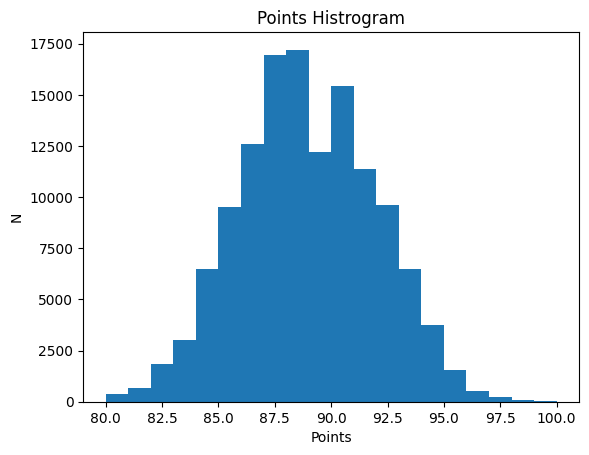

In [8]:
plt.hist(df.points, bins=20)
plt.title("Points Histrogram")
plt.ylabel('N')
plt.xlabel('Points')
plt.show()

In [21]:
df["label"] = (df.points >= 90).astype(int)
df = df[['description', 'label']]

AttributeError: ignored

In [22]:
df.tail()

,description,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


In [23]:
train, valid, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [24]:
len(train), len(valid), len(test)

(103976, 12997, 12998)

In [25]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [26]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(valid)
test_data = df_to_dataset(test)

In [27]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [28]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.54437536,  0.0081133 ,  0.37800288, ...,  0.07348322,
         0.13696246, -0.02696376],
       [ 0.52266884, -0.2868    ,  0.09415048, ...,  0.07427676,
         0.02400145, -0.13883844],
       [ 0.6035937 , -0.14328   , -0.01332018, ..., -0.11376379,
        -0.12741609,  0.01654172],
       ...,
       [ 0.25139964, -0.09834495, -0.22898564, ...,  0.08344948,
        -0.10532933, -0.05728543],
       [ 0.33794382, -0.16699442,  0.17233878, ..., -0.04981021,
        -0.11364997, -0.14077896],
       [ 0.44161734, -0.22394554, -0.123688  , ..., -0.25639665,
        -0.36115652,  0.04529677]], dtype=float32)>

In [40]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [42]:
model.evaluate(train_data)

102/102 [==============================] - 19s 182ms/step - loss: 0.7147 - accuracy: 0.3819


[0.714663565158844, 0.38192468881607056]

In [43]:
model.evaluate(valid_data)

13/13 [==============================] - 2s 164ms/step - loss: 0.7160 - accuracy: 0.3792


[0.7159527540206909, 0.37924137711524963]

In [52]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 132s 1s/step - loss: 0.2660 - accuracy: 0.8959 - val_loss: 0.4421 - val_accuracy: 0.8235
Epoch 2/5
102/102 [==============================] - 131s 1s/step - loss: 0.2567 - accuracy: 0.8984 - val_loss: 0.4490 - val_accuracy: 0.8233
Epoch 3/5
102/102 [==============================] - 132s 1s/step - loss: 0.2492 - accuracy: 0.9024 - val_loss: 0.4522 - val_accuracy: 0.8209
Epoch 4/5
102/102 [==============================] - 128s 1s/step - loss: 0.2403 - accuracy: 0.9047 - val_loss: 0.4689 - val_accuracy: 0.8224
Epoch 5/5
102/102 [==============================] - 130s 1s/step - loss: 0.2295 - accuracy: 0.9100 - val_loss: 0.4915 - val_accuracy: 0.8228


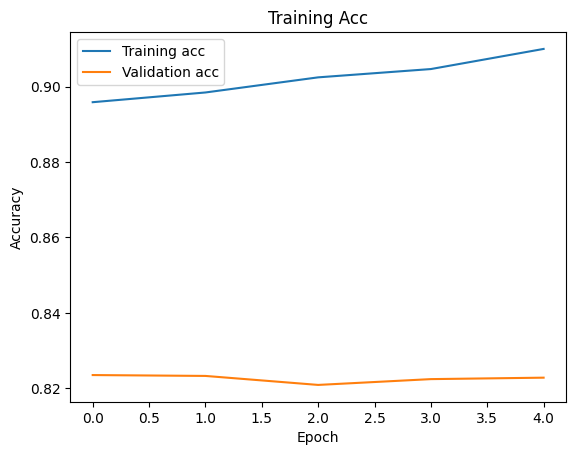

In [53]:
plt.plot(history.history["accuracy"], label="Training acc")
plt.plot(history.history["val_accuracy"], label="Validation acc")
plt.title("Training Acc")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

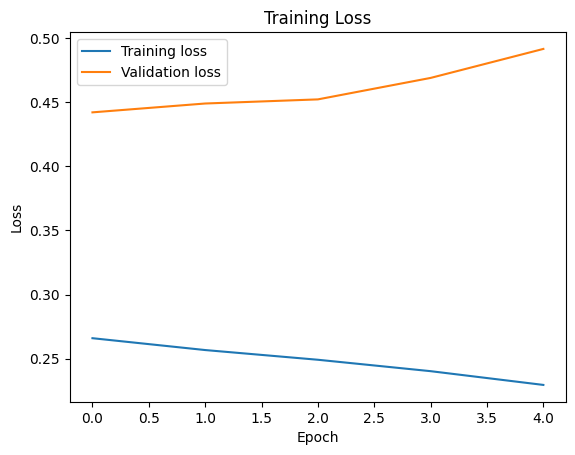

In [54]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# LSTM


In [56]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [57]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [60]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 32,
        mask_zero = True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid'),

])

In [61]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [62]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 4s 303ms/step - loss: 0.6931 - accuracy: 0.5163


[0.693070650100708, 0.5163499116897583]

In [63]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 64s 544ms/step - loss: 0.5374 - accuracy: 0.7175 - val_loss: 0.3741 - val_accuracy: 0.8323
Epoch 2/5
102/102 [==============================] - 55s 530ms/step - loss: 0.3653 - accuracy: 0.8364 - val_loss: 0.3491 - val_accuracy: 0.8420
Epoch 3/5
102/102 [==============================] - 53s 518ms/step - loss: 0.3470 - accuracy: 0.8456 - val_loss: 0.3463 - val_accuracy: 0.8445
Epoch 4/5
102/102 [==============================] - 56s 546ms/step - loss: 0.3406 - accuracy: 0.8483 - val_loss: 0.3469 - val_accuracy: 0.8440
Epoch 5/5
102/102 [==============================] - 55s 536ms/step - loss: 0.3349 - accuracy: 0.8504 - val_loss: 0.3526 - val_accuracy: 0.8415


In [64]:
model.evaluate(test_data)

13/13 [==============================] - 5s 401ms/step - loss: 0.3487 - accuracy: 0.8347


[0.34872967004776, 0.8346668481826782]